# RIR mixing해서 생성한 dataset에 대해 AEC 하여 ELRE를 계산한다

In [7]:
import glob
import os
import numpy as np
import soundfile as sf
import AEC_speex as aec
from tqdm import tqdm
import re

In [2]:
save_path = '/home/nas3/project/2023_LG_HA/data/240911_AEC_simulation_dataset/'
save_folder =['clean_speech/', 'speech_rir/', 'echo_rir/', 'clean_echo/', 'mixture/']

file_list = []
for folder in save_folder:
    file_list.append(glob.glob(save_path + folder + '*.wav'))

len(file_list), len(file_list[0]), len(file_list[1]), len(file_list[2]), len(file_list[3]), len(file_list[4])

(5, 225, 225, 225, 225, 225)

### Define AEC

In [3]:
# Import data
ERLE_arr = []
SNR_arr = []

len = len(file_list[0])
s_folder = ['processed_output/', 'estimated_echo/']
os.makedirs(save_path + f'{s_folder[0]}', exist_ok=True)
os.makedirs(save_path + f'{s_folder[1]}', exist_ok=True)

for i in range(len):
    match = re.search(r'_SNR_(-?\d+\.\d+)', file_list[4][i])
    if match:
        snr_value = match.group(1)
        SNR_arr.append(snr_value)
        
for idx in tqdm(range(len)):
    s, _ = sf.read(file_list[0][idx])
    s_rir, _ = sf.read(file_list[1][idx])
    e_rir, _ = sf.read(file_list[2][idx])
    e, _ = sf.read(file_list[3][idx])
    x, sr = sf.read(file_list[4][idx])

    # load metric
    aec_speech, aec_echo = aec.run_AEC(e, x, sr, processor=aec.MDF,
                                # output_filename="AEC_RIRMIX"
                                )
    
    sf.write(save_path + s_folder[0] + f'{idx}_SNR_{SNR_arr[idx]}_processed_output.wav', aec_speech, sr)
    sf.write(save_path + s_folder[1] + f'{idx}_SNR_{SNR_arr[idx]}_estimated_echo.wav',   aec_echo,   sr)

    erle = aec.calculate_erle(e_rir, aec_echo, dropout=0.2,tag='simulation', opt_print=False)
    ERLE_arr.append(erle)
    


100%|██████████| 225/225 [09:17<00:00,  2.48s/it]


Text(0.5, 1.0, 'ERLE (dB): 15.650')

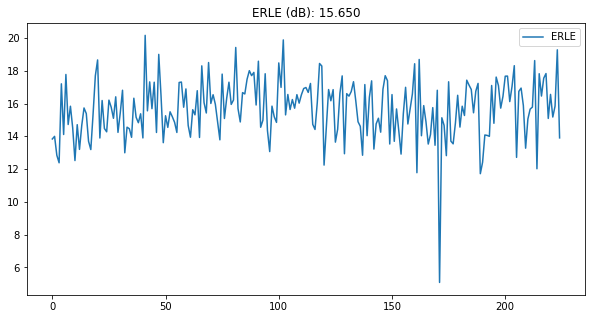

In [4]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.plot(ERLE_arr, label='ERLE')
plt.legend()
plt.title(f"ERLE (dB): {np.mean(ERLE_arr):.3f}")
         

In [5]:
max(s), max(s_rir), max(e_rir), max(e), max(x)

(0.469573974609375,
 0.284210205078125,
 0.616546630859375,
 0.141693115234375,
 0.616546630859375)

In [9]:
# # ERLE graph
# import matplotlib.pyplot as plt

# win_erle_1 = aec.windowed_calculate_erle(e_rir, aec_echo, tag='simulation')

# plt.figure(figsize=(20, 5))
# plt.plot(win_erle_1, label="ERLE")
# plt.legend()

# spacing = int(len(x)/(1024*5))  # 간격
# for xc in range(0, len(win_erle_1), spacing):
#     plt.axvline(x=xc, color='gray', linestyle='--', alpha=0.7)
    
# plt.title(f"ERLE (dB): {erle:.3f}")
# plt.show()

In [55]:
import IPython.display as ipd
ipd.Audio(file_list[4][idx], rate=16000)

In [56]:
ipd.Audio(aec_echo, rate=16000)